In [1]:
!nvidia-smi

Wed Sep  2 05:40:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

import string

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


224 bicubic to VAE
-------

In [5]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 30
verbose = 2
N_dim = 224
ModelName = 'VAE_224'
latent_dim = 2

In [6]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    train_data = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv')
    train_data_pixel = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic'+str(N_dim)+'.csv')

    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, N_dim, N_dim, 1)

    fix = train_data.iloc[:, 1:3].values
    with tf.device('/device:GPU:0'):
        datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                          height_shift_range=0.1)
        gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
        pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
        while batch_index <= limit:
            try:
                data = gen.next()
                pixel += list(data[0])
                fixed += list(data[1])
                batch_index += 1
            except:
                print("ImageGeneratorError")
                break
    fixed_train = np.asarray(fixed)
    X_train_pixel = np.asarray(pixel)
    Y_train = to_categorical(fixed_train[:, 0], 10)
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])


    return X_train_label, X_train_pixel, Y_train

X_train_label, X_train_pixel, Y_train = ComputerVision_Dataset()

Boundary Clear


In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def VAE_make_and_train():
    with tf.device('/device:GPU:0'):
        # Encoder
        encoder_inputs = keras.Input(shape=(N_dim, N_dim, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation="relu")(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = keras.Model(encoder_inputs, z, name="encoder")
        #print(encoder.summary())
        # Decoder
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(64, activation="relu")(latent_inputs)
        x = layers.Dense(7*7*128, activation="relu")(x)
        x = layers.Reshape((7, 7, 128))(x)
        x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        #print(decoder.summary())
        # VAE = [Encoder -> Decoder]
        outputs = decoder(encoder.output)
        vae = tf.keras.Model(inputs=encoder.input, outputs=outputs, name="vae")
        #print(vae.summary())
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        vae.add_loss(kl_loss)

        # Train.
        vae.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError(), metrics=["accuracy"])
        vae.fit(X_train_pixel, X_train_pixel, epochs=epochs_num, batch_size=64)

    vae.save(path + ModelName + '.h5')

    return vae

In [8]:
VAE = VAE_make_and_train()

Epoch 1/30
321/321 [==============================] - 31s 96ms/step - loss: 0.0492 - accuracy: 0.0000e+00
Epoch 2/30
321/321 [==============================] - 31s 95ms/step - loss: 0.0417 - accuracy: 0.0000e+00
Epoch 3/30
321/321 [==============================] - 30s 95ms/step - loss: 0.0417 - accuracy: 0.0000e+00
Epoch 4/30
321/321 [==============================] - 30s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 5/30
321/321 [==============================] - 30s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 6/30
321/321 [==============================] - 31s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 7/30
321/321 [==============================] - 30s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 8/30
321/321 [==============================] - 30s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 9/30
321/321 [==============================] - 31s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 10/30
321/321 [=========================

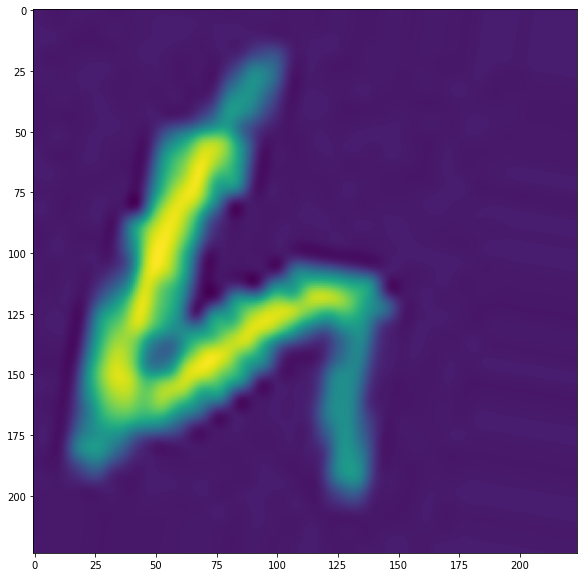

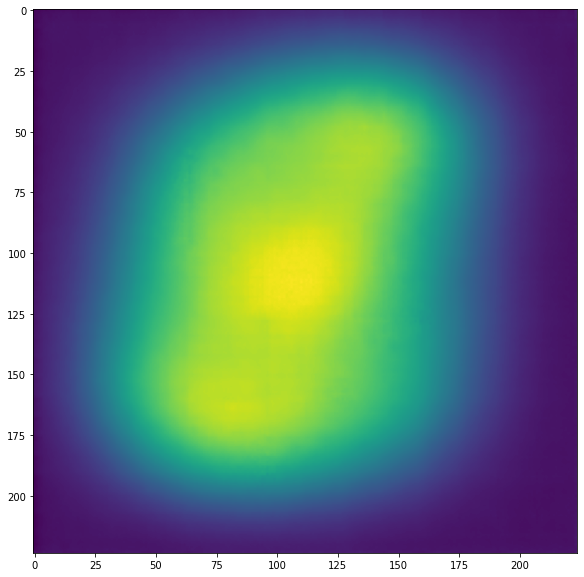

In [10]:
def image_view(pixels):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
num = 10
test1 = VAE.predict(X_train_pixel[num].reshape(1,224,224,1))
image_view(X_train_pixel[num].reshape(224,224))
image_view(test1.reshape(224,224))

https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981

implemented to 224

In [12]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

class VAE_MNIST(tfk.Model):
    
    def __init__(self, dim_z, kl_weight=1, name="autoencoder", **kwargs):
        super(VAE_MNIST, self).__init__(name=name, **kwargs)
        self.dim_x = (224, 224, 1)
        self.dim_z = dim_z
        self.encoder = self.encoder_z()
        self.decoder = self.decoder_x()
        self.kl_weight = kl_weight
        
    # Sequential API encoder
    def encoder_z(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_x)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=128, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.GlobalAveragePooling2D())
        layers.append(tfkl.Flatten())
        # *2 because number of parameters for both mean and (raw) standard deviation
        layers.append(tfkl.Dense(self.dim_z*2, activation=None))
        return tfk.Sequential(layers)
    
    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1+tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        layers.append(tfkl.Dense(7*7*128, activation=None))
        layers.append(tfkl.Reshape((7,7,128)))
        layers.append(tfkl.Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        return tfk.Sequential(layers, name='decoder')
    
    def call(self, x_input):
        z_sample, mu, sd = self.encode(x_input)
        kl_divergence = tf.math.reduce_mean(- 0.5 * 
                tf.math.reduce_sum(1+tf.math.log(
                tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1))
        x_logits = self.decoder(z_sample)
        # VAE_MNIST is inherited from tfk.Model, thus have class method add_loss()
        self.add_loss(self.kl_weight * kl_divergence)
        return x_logits
    
# custom loss function with tf.nn.sigmoid_cross_entropy_with_logits
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    return tf.math.reduce_mean(neg_log_likelihood)

  
####################   The following code shows how to train the model   ####################
# set hyperparameters
epochs = 20
batch_size = 32
lr = 0.0001
latent_dim=16
kl_w=3
# compile and train tfk.Model
with tf.device('/device:GPU:0'):
    vae = VAE_MNIST(dim_z=latent_dim, kl_weight=kl_w)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                loss=custom_sigmoid_cross_entropy_loss_with_logits)
    train_history = vae.fit(x=X_train_pixel, y=X_train_pixel, batch_size=batch_size, epochs=epochs)
vae.save(path + ModelName + '_modified.h5')

Epoch 1/20
641/641 [==============================] - 31s 49ms/step - loss: 24376.5547
Epoch 2/20
641/641 [==============================] - 31s 49ms/step - loss: 22708.2598
Epoch 3/20
641/641 [==============================] - 31s 49ms/step - loss: 22553.9707
Epoch 4/20
641/641 [==============================] - 31s 49ms/step - loss: 22382.0488
Epoch 5/20
641/641 [==============================] - 31s 49ms/step - loss: 21976.5703
Epoch 6/20
641/641 [==============================] - 31s 49ms/step - loss: 21766.1680
Epoch 7/20
641/641 [==============================] - 31s 49ms/step - loss: 21633.2773
Epoch 8/20
641/641 [==============================] - 31s 49ms/step - loss: 21456.6934
Epoch 9/20
641/641 [==============================] - 31s 49ms/step - loss: 21318.5254
Epoch 10/20
641/641 [==============================] - 31s 49ms/step - loss: 21200.9805
Epoch 11/20
641/641 [==============================] - 31s 48ms/step - loss: 21105.5000
Epoch 12/20
641/641 [====================

NotImplementedError: ignored

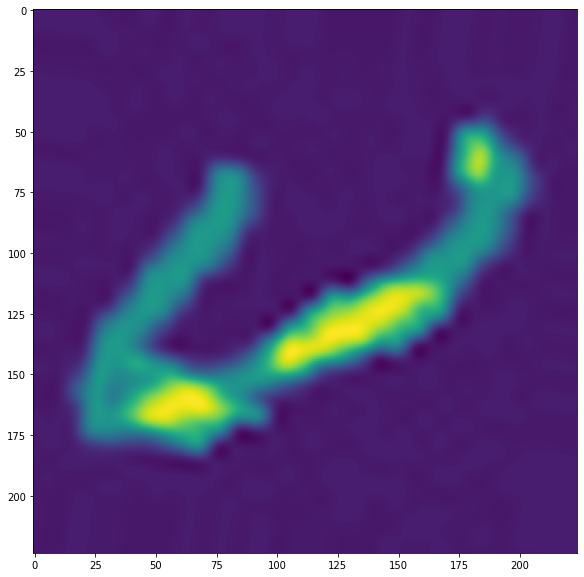

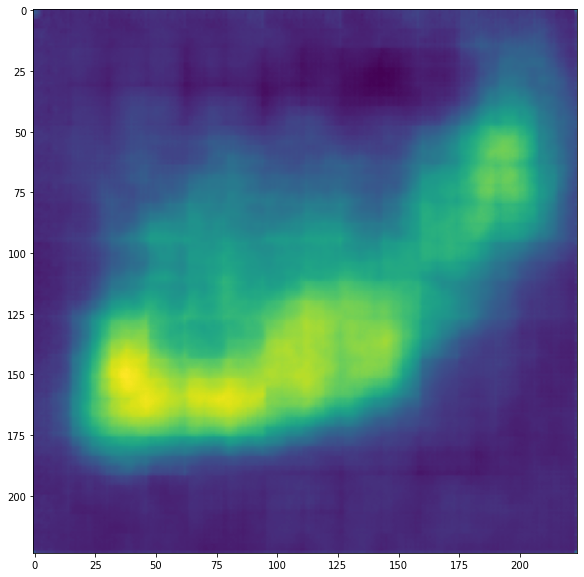

In [17]:
def image_view(pixels):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
num = 20
test1 = vae.predict(X_train_pixel[num].reshape(1,224,224,1))
image_view(X_train_pixel[num].reshape(224,224))
image_view(test1.reshape(224,224))

28 original to VAE
-----------

In [12]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 2
epochs_num = 30
verbose = 2
N_dim = 28
ModelName = 'VAE_28'
latent_dim = 2

In [13]:
def normalization(df):
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    train_data = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv')

    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data.iloc[:, 3:]
    pix = normalization(pix).values.reshape(-1, N_dim, N_dim, 1)

    fix = train_data.iloc[:, 1:3].values

    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                       height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    fixed_train = np.asarray(fixed)
    X_train_pixel = np.asarray(pixel)
    Y_train = to_categorical(fixed_train[:, 0], 10)
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])


    return X_train_label, X_train_pixel, Y_train

X_train_label, X_train_pixel, Y_train = ComputerVision_Dataset()

Boundary Clear


In [16]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32
X_train_pixel = X_train_pixel.reshape(-1,784)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(X_train_pixel, X_train_pixel, epochs=epochs_num, batch_size=64)

Epoch 1/30
65/65 [==============================] - 0s 3ms/step - loss: 0.1101
Epoch 2/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0534
Epoch 3/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0488
Epoch 4/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0478
Epoch 5/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0474
Epoch 6/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0472
Epoch 7/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0471
Epoch 8/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0469
Epoch 9/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0469
Epoch 10/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0468
Epoch 11/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0468
Epoch 12/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0468
Epoch 13/30
65/65 [==============================

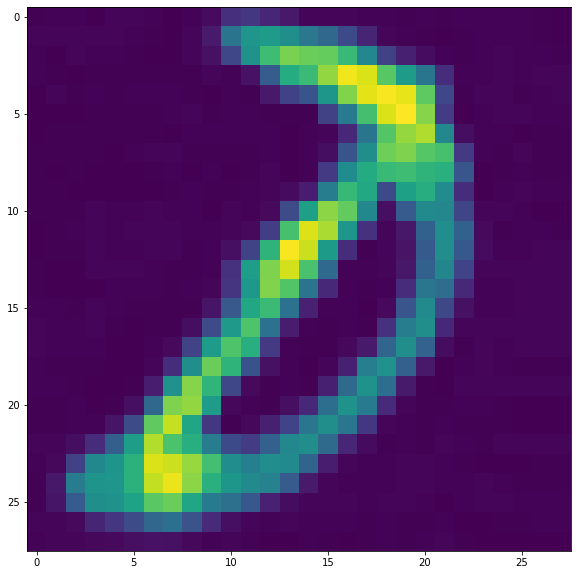

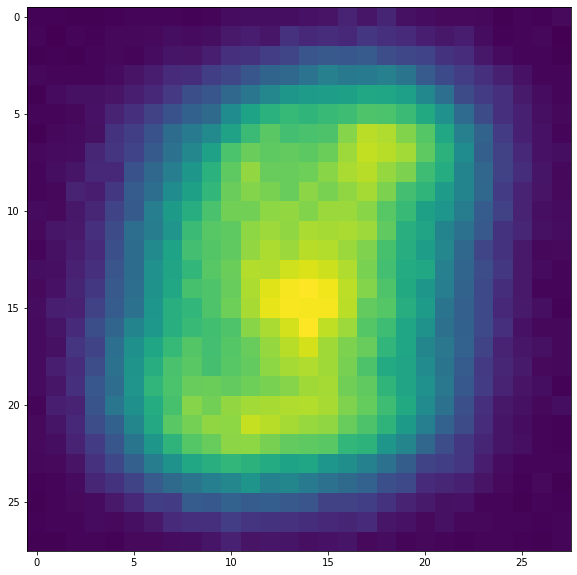

In [18]:
def image_view(pixels):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
num = 3
test1 = vae.predict(X_train_pixel[num].reshape(1,784))
image_view(X_train_pixel[num].reshape(28,28))
image_view(test1.reshape(28,28))

https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

class VAE_MNIST(tfk.Model):
    
    def __init__(self, dim_z, kl_weight=1, name="autoencoder", **kwargs):
        super(VAE_MNIST, self).__init__(name=name, **kwargs)
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.encoder = self.encoder_z()
        self.decoder = self.decoder_x()
        self.kl_weight = kl_weight
        
    # Sequential API encoder
    def encoder_z(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_x)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # *2 because number of parameters for both mean and (raw) standard deviation
        layers.append(tfkl.Dense(self.dim_z*2, activation=None))
        return tfk.Sequential(layers)
    
    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1+tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        layers.append(tfkl.Dense(7*7*32, activation=None))
        layers.append(tfkl.Reshape((7,7,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        return tfk.Sequential(layers, name='decoder')
    
    def call(self, x_input):
        z_sample, mu, sd = self.encode(x_input)
        kl_divergence = tf.math.reduce_mean(- 0.5 * 
                tf.math.reduce_sum(1+tf.math.log(
                tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1))
        x_logits = self.decoder(z_sample)
        # VAE_MNIST is inherited from tfk.Model, thus have class method add_loss()
        self.add_loss(self.kl_weight * kl_divergence)
        return x_logits
    
# custom loss function with tf.nn.sigmoid_cross_entropy_with_logits
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    return tf.math.reduce_mean(neg_log_likelihood)

  
####################   The following code shows how to train the model   ####################
# set hyperparameters
epochs = 10
batch_size = 32
lr = 0.0001
latent_dim=16
kl_w=3
# compile and train tfk.Model
with tf.device('/device:GPU:0'):
    vae = VAE_MNIST(dim_z=latent_dim, kl_weight=kl_w)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                loss=custom_sigmoid_cross_entropy_loss_with_logits)
    train_history = vae.fit(x=X_train_pixel, y=X_train_pixel, batch_size=batch_size, epochs=epochs, 
                            verbose=1, validation_data=(test_images, test_images), shuffle=True)
vae.save(path + ModelName + '_modified.h5')

In [ ]:
def image_view(pixels):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
num = 3
test1 = vae.predict(X_train_pixel[num].reshape(1,28,28,1))
image_view(X_train_pixel[num].reshape(28,28))
image_view(test1.reshape(28,28))